In [178]:
# 라이브러리 import
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt

In [208]:
# 파일 불러와서 데이터프레임으로

# 구글드라이브 마운트 경로 설정
drive_path = '/content/drive/MyDrive/data/'
# 환율 CSV 파일 로드
data  = pd.read_table(drive_path + 'exchange_rate.csv', sep=",", thousands=',', encoding='CP949')
# 결측치 제거
data  = data.dropna()
# 일본만 선택해서 테스트
data  = data [data['국가명'] == '일본']
# 날짜를 인덱스로 설정
data['날짜'] = pd.to_datetime(data['날짜'])
data.set_index('날짜', inplace=True)
target_data = data[data.index.year >= 2022]
# 필요한 열 선택
data = data[['매매기준율', 'DAX', 'VN', 'S&P 500', 'KOSPI', 'FTSE', 'DOWJONES', 'NIKKEI', 'NASDAQ']]
data.head()

,매매기준율,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
날짜,,,,,,,,,
2016-01-04,992.62,10283.44,574.41,2012.66,235.00,6093.43,17148.94,18450.98,4497.86
2016-01-05,993.00,10310.10,569.94,2016.71,236.40,6137.24,17158.66,18374.00,4484.18
2016-01-06,1005.06,10214.02,574.57,1990.26,235.45,6073.38,16906.51,18191.32,4443.98
2016-01-07,1016.95,9979.85,565.36,1943.09,232.50,5954.08,16514.10,17767.34,4305.72
2016-01-08,1013.12,9849.34,560.05,1922.03,233.80,5912.44,16346.45,17697.96,4270.78


In [209]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
train_data = scaled_data[data.index.year <= 2021]
test_data = scaled_data[data.index.year >= 2022]
tmp = data[data.index.year >= 2022]

In [210]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 60  # 과거 60일의 데이터를 기반으로 예측
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:, :]  # 예측 대상은 모든 칼럼
X_test = create_sequences(test_data, seq_length)

In [211]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(9))  # 출력 레이어 (9개의 칼럼)

model.compile(optimizer='SGD', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
42/42 [==============================] - 2s 18ms/step - loss: 0.2862
Epoch 2/50
42/42 [==============================] - 1s 18ms/step - loss: 0.1547
Epoch 3/50
42/42 [==============================] - 1s 18ms/step - loss: 0.0727
Epoch 4/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0322
Epoch 5/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0237
Epoch 6/50
42/42 [==============================] - 1s 23ms/step - loss: 0.0209
Epoch 7/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0194
Epoch 8/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0183
Epoch 9/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0172
Epoch 10/50
42/42 [==============================] - 1s 18ms/step - loss: 0.0163
Epoch 11/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0155
Epoch 12/50
42/42 [==============================] - 1s 18ms/step - loss: 0.0149
Epoch 13/50
42/42 [==================

In [212]:
# 테스트 데이터의 마지막 시퀀스를 사용하여 미래 예측
last_sequence = X_test[-1]
future_predictions = []

# 미래 예측값 생성
for _ in range(180):  # 예측 기간 설정 (365일)
    next_day_prediction = model.predict(np.array([last_sequence]))
    future_predictions.append(next_day_prediction[0])
    last_sequence = np.roll(last_sequence, shift=-1, axis=0)  # 시퀀스 업데이트
    last_sequence[-1] = next_day_prediction[0]  # 마지막 값 업데이트

# 스케일링 역변환
future_predictions = scaler.inverse_transform(future_predictions)


1/1 [==============================] - 0s 27ms/step


In [213]:

# 예측 결과를 DataFrame으로 변환하고 날짜 인덱스 생성
prediction_dates = pd.date_range(start=tmp.index[0] + pd.Timedelta(days=1), periods=len(future_predictions))
predicted_df = pd.DataFrame(future_predictions, columns=['매매기준율','DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ'], index=prediction_dates)
# prediction_dates
predicted_df.head()

,매매기준율,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
2022-01-05,1032.668700,12932.576127,1179.017914,3315.190459,347.528199,7307.613023,30801.194453,25432.825786,11767.831663
2022-01-06,1032.473613,13058.921112,1163.660464,3349.984806,348.717674,7296.409648,30923.432486,25313.205214,11712.650107
2022-01-07,1035.048589,13153.394227,1153.099625,3394.911028,349.009979,7275.038287,30800.771969,25366.468180,11586.062757
2022-01-08,1037.532217,13245.124505,1147.466086,3429.639440,349.336209,7261.706838,30695.168739,25396.804049,11491.347197
2022-01-09,1039.503219,13323.035131,1144.513499,3458.606018,349.822999,7253.401416,30592.298486,25416.486763,11423.180118


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

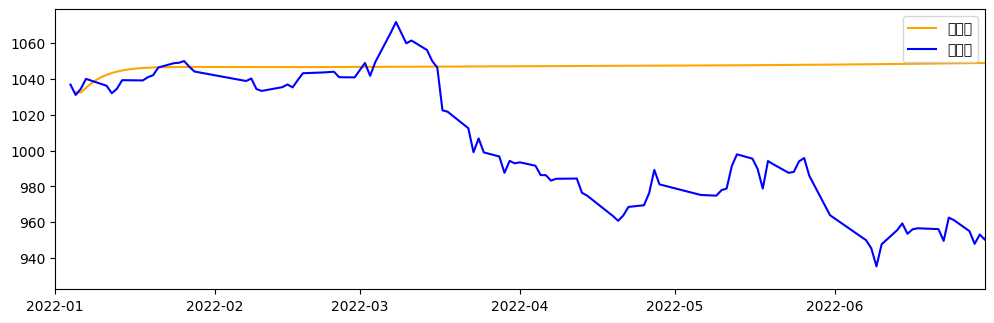

In [214]:
# 예측 매매기준율 시각화

plt.figure(figsize=(12,8))
plt.subplot(212)
plt.plot(predicted_df[['매매기준율']],'orange', label='예측치')
plt.plot(tmp[['매매기준율']],'blue', label='실제값')
plt.xlim([datetime.date(2022, 1, 1), datetime.date(2022, 6, 30)])
plt.legend()
plt.show()

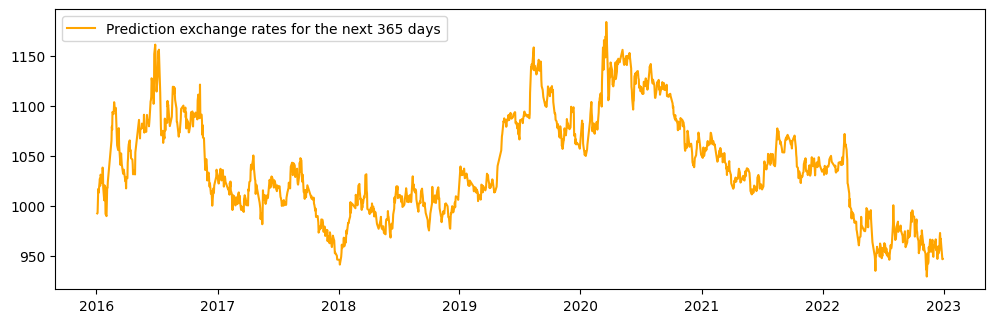

In [105]:
# 전체 환율 데이터 시각화

plt.figure(figsize=(12,8))
plt.subplot(212)
plt.plot(data[['매매기준율']],'orange')
plt.legend(['Prediction exchange rates for the next 365 days'])
plt.show()